In [176]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [177]:
# Setting hyperparameters
batch_size = 64
epochs = 15
learning_rate = 0.0001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
model_type = "Attention Encoder-Decoder"

In [178]:
df = pd.read_csv("data/ac_data.csv")

df.head()

,date_time,temperature_datetime,temperature,airQuality_datetime,airQuality
0,2023-06-11 01:07:06.889863,2023-6-10-17-7-7,25.3750,2023-6-10-17-7-9,449
1,2023-06-11 01:12:07.465380,2023-6-10-17-12-4,25.3125,2023-6-10-17-12-8,461
2,2023-06-11 01:17:08.019617,2023-6-10-17-17-5,25.3125,2023-6-10-17-17-7,454
3,2023-06-11 01:22:08.641555,2023-6-10-17-22-8,25.1875,2023-6-10-17-22-9,460
4,2023-06-11 01:27:09.215907,2023-6-10-17-27-5,25.0625,2023-6-10-17-27-7,482


In [179]:
# Generating dataset

class device_data(Dataset):
    def __init__(self, X, window, horizon=0):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window-1
        for i in range(0, len(X)-window-1-horizon):
            self.X.append(X[i:window+i])
            self.y.append(X[window+i: window+i+horizon+1])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [180]:
scaler = MinMaxScaler()
scaler.fit(df["temperature"].to_numpy().reshape(-1, 1))
data = scaler.transform(df["temperature"].to_numpy().reshape(-1, 1))

In [181]:
# Sequence lenght is 12. 1 hr duration
window = 12
horizon = 4

In [182]:
train = device_data(data.squeeze()[:800], window, horizon)
val = device_data(data.squeeze()[800:900], window, horizon)
test = device_data(data.squeeze()[900:], window, horizon)

In [183]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

In [184]:
dataset_iter = iter(val_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([64, 12]) torch.Size([64, 1, 5])


In [185]:
# dataset_iter = iter(train_loader)
dataset_iter = iter(test_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([64, 12]) torch.Size([64, 1, 5])


In [186]:
class Encoder(nn.Module):
    def __init__(self, seq_len, input_shape, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden = hidden_size
        self.input_shape = input_shape
        self.gru = nn.GRU(input_shape, hidden_size, num_layers, batch_first=True)

    def forward(self, input):
        # input [batch, window]
        # hidden = torch.zeros([self.num_layers, self.hidden]).cuda()
        # hidden = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
        output, hidden = self.gru(input)
        return output, hidden

In [187]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_shape, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.hidden = hidden_size
        self.input_shape = input_shape
        self.gru = nn.GRU(input_shape + hidden_size, hidden_size, num_layers, batch_first=True)

        # For computing attention
        self.w1 = nn.Linear(hidden_size, hidden_size)
        self.w2 = nn.Linear(hidden_size, hidden_size)
        self.w3 = nn.Linear(hidden_size, 1)

        # Initialize fully connected layer
        self.final = nn.Linear(hidden_size, 1)

    def compute_attention(self, dec_hs, enc_output):
        # dec_hs: Decoder hidden state; [1, batch_size, hidden_units]
        # enc_output: Encoder outputs; [batch_size, window, hidden_units]
        dec_x = dec_hs.permute(1, 0, 2)

        # context_vector: Context vector, according to formula; [batch_size, hidden_units]
        # attention_weights: The attention weights you have calculated; [batch_size, max_len_src, 1]

        # alignment scores e(j,t)
        out = torch.tanh(self.w1(dec_x) + self.w2(enc_output))
        out = self.w3(out)

        # he scores e(j,t) are normalized using softmax function over the encoder time steps j, obaining the attention weights α(j,t)
        soft = nn.Softmax(dim=1)
        attention = soft(out)

        #  The context vector c(t) is calculated as the weighted sum of all the hidden values of the encoder according to the attention weights
        # context vector [batch_size, hidden_units]
        # attention weights [batch_size, max_len_src, 1]
        context_vector, attention_weights = torch.sum(
            attention * enc_output, dim=1), attention
        return context_vector, attention_weights


    def forward(self, input, dec_hs, enc_output):
        # **This function runs the decoder for a single time step.**
        # input [batch_size, 1]

        # hidden = torch.zeros([self.num_layers, self.hidden]).cuda()
        # hidden = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()

        context_vector, attention_weights = self.compute_attention(dec_hs, enc_output)
        # context vector [batch, hidden_size]
        s = input.size(0)
        # print(context_vector.unsqueeze(1).shape, input.reshape(s, 1, 1).shape)
        out = torch.cat((context_vector.unsqueeze(1), input.reshape(s, 1, 1)), 2)
        fc_out, dec_hs = self.gru(out)
        output = self.final(fc_out)
        final_out = torch.flatten(output, start_dim = 1)

        return final_out, dec_hs, attention_weights

In [188]:
# Test encoder model,
input_shape = 1
enc_test = Encoder(window, input_shape, hidden_shape, num_layers=num_layer).cuda()
# (seq,btch,in_sh)
out, h = enc_test(features.unsqueeze(2).cuda())
print(out.shape, h.shape)

torch.Size([64, 12, 64]) torch.Size([1, 64, 64])


In [189]:
# Test decoder model,
input_shape = 1
dec_test = Decoder(window, input_shape, hidden_shape, num_layers=1).to(device)
# (seq,btch,in_sh)
input = features[:, 0].to(device)
dec_hs = torch.zeros([num_layer, batch_size, hidden_shape]).to(device)
out, dec_hs, att = dec_test(input, dec_hs, out)
print(out.shape, dec_hs.shape, att.shape)

torch.Size([64, 1]) torch.Size([1, 64, 64]) torch.Size([64, 12, 1])


In [190]:
input_shape = 1
encoder = Encoder(window, input_shape, hidden_shape, num_layers=1).to(device)

decoder = Decoder(window, input_shape, hidden_shape, num_layers=1).to(device)

In [191]:
criterion = nn.MSELoss()
rnn_model_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(rnn_model_params, lr=learning_rate)

Epoch:1, train loss: 0.3531100331650426, val loss: 0.29576703906059265
Epoch:2, train loss: 0.33045237748107564, val loss: 0.27402159571647644
Epoch:3, train loss: 0.3084524809770907, val loss: 0.25274690985679626
Epoch:4, train loss: 0.2867882529972121, val loss: 0.23163990676403046
Epoch:5, train loss: 0.2651295952770549, val loss: 0.21038691699504852
Epoch:6, train loss: 0.2431569745434293, val loss: 0.18870900571346283
Epoch:7, train loss: 0.2206038537551649, val loss: 0.1664072722196579
Epoch:8, train loss: 0.19729686136512706, val loss: 0.14339762926101685
Epoch:9, train loss: 0.17318857581509897, val loss: 0.11975409090518951
Epoch:10, train loss: 0.14841519086621702, val loss: 0.09579921513795853
Epoch:11, train loss: 0.12341678437466423, val loss: 0.07227455824613571
Epoch:12, train loss: 0.09914691276693095, val loss: 0.05058866739273071
Epoch:13, train loss: 0.0773067978831629, val loss: 0.032937999814748764
Epoch:14, train loss: 0.06023949466180056, val loss: 0.021669808775

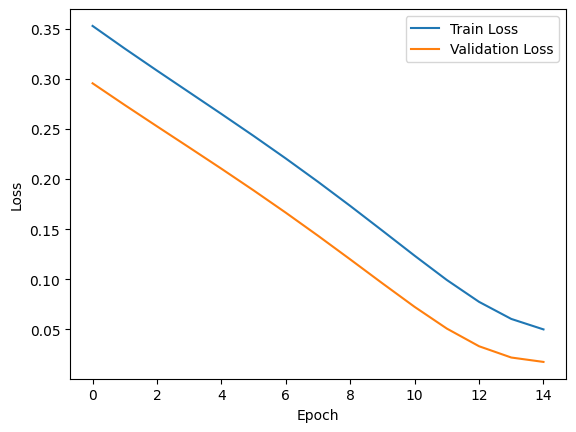

In [192]:
loss_train = []
loss_val = []

for epoch in range(epochs):
    n_batch = 0
    total_loss = 0
    total_val = 0

    # Training loop
    encoder.train()
    decoder.train()
    for batch_x, batch_y in train_loader:
        n_batch += 1
        mse_train = 0
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_x = batch_x.unsqueeze(2)
        batch_y = batch_y.permute(0, 2, 1)
        optimizer.zero_grad()

        enc_output, enc_hidden = encoder(batch_x)
        dec_hidden = enc_hidden

        # use teacher forcing - feeding the target as the next input (via dec_input)
        dec_input = batch_y[:, 0].view(batch_size, 1, 1)

        # run code below for every timestep in the ys batch
        for t in range(1, batch_y.size(1)):
            predictions, dec_hidden, _ = decoder(dec_input.to(device), dec_hidden.to(device), enc_output)
            mse_train_step = criterion(batch_y[:, t], predictions)
            mse_train += mse_train_step
            dec_input = batch_y[:, t].view(batch_y.size(0), 1, 1)

        batch_loss = mse_train / (batch_y.size(1) - 1 + 1)
        total_loss += batch_loss.item()

        batch_loss.backward()
        optimizer.step()

    # Validation loop
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_x = batch_x.unsqueeze(2)
            batch_y = batch_y.permute(0, 2, 1)

            encoder_output, encoder_hidden = encoder(batch_x)
            dec_input = batch_y[:, 0].view(batch_size, 1, 1)
            dec_hidden = encoder_hidden
            mse_val = 0

            for t in range(1, batch_y.size(1)):
                predictions, dec_hidden, _ = decoder(dec_input.to(device), dec_hidden.to(device), encoder_output)
                mse_val_step = criterion(batch_y[:, t], predictions)
                mse_val += mse_val_step
                dec_input = batch_y[:, t].view(batch_size, 1, 1)

            batch_loss = mse_val / (batch_y.size(1) - 1 + 1)
            total_val += batch_loss.item()

    print(f"Epoch:{epoch+1}, train loss: {total_loss/n_batch}, val loss: {total_val/len(val_loader)}")

    loss_train.append(total_loss/n_batch)
    loss_val.append(total_val/len(val_loader))

plt.plot(loss_train, label='Train Loss')
plt.plot(loss_val, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [193]:
with torch.no_grad():
  preds = []
  true = []
  total_loss = 0
  n_batch = 0
  for batch_x, batch_y in test_loader:
        n_batch += 1
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.unsqueeze(2)
        batch_y = batch_y.permute(0, 2, 1)
        temp = batch_y.squeeze()
        true.extend(scaler.inverse_transform(temp.reshape(-1, 1).detach().cpu().numpy()))
        encoder_output, encoder_hidden = encoder(batch_x)
        dec_input = batch_y[:, 0].view(batch_size, 1, 1)
        temp = dec_input.detach().cpu().numpy()
        preds.append(scaler.inverse_transform(temp.reshape(-1, 1)))

        dec_hidden = encoder_hidden
        for t in range(1, batch_y.size(1)):
          predictions, dec_hidden, _ = decoder(dec_input.to(device), dec_hidden.to(device), enc_output.to(device))
          best_guess = predictions.detach().cpu().numpy()
          preds.append(scaler.inverse_transform(best_guess.reshape(-1, 1)))
          dec_input = predictions.view(batch_y.size(0), 1, 1)



  preds = np.concatenate(preds)
  true = np.concatenate(true)
  mse = mean_squared_error(true, preds)
  mae = mean_absolute_error(true, preds)

  print(mse, mae)

3.7973428 1.4276516


In [194]:
print(preds.shape, true.shape)

(640, 1) (640,)


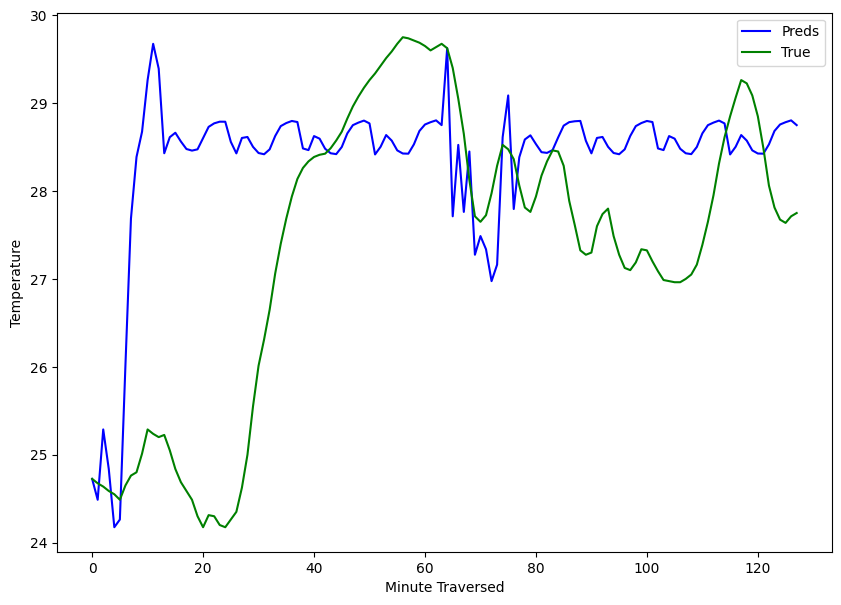

In [196]:
# Reshape the arrays into a 2D shape with each row representing 500 data points
preds_reshaped = preds.reshape(128, 5)
true_reshaped = true.reshape(128, 5)

# Take the average along each row
preds_avg = np.mean(preds_reshaped, axis=1)
true_avg = np.mean(true_reshaped, axis=1)

# Plot the averages
plt.figure(figsize=(10, 7))
plt.plot(preds_avg, 'b', label='Preds')
plt.plot(true_avg, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()